In [ ]:
# Dependencies and setup
import torch
import torchvision
import torchvision.transforms as transforms

import numpy as np
import torch as th
import os
import cv2
import pandas as pd

import torch.nn as nn
import torch.nn.functional as F

import time

import shutil

import os

from google.colab.patches import cv2_imshow

from google.colab import drive
# drive.mount('/content/drive')
root = '/content/Data'

In [ ]:
!unzip -u /content/Data.zip

In [ ]:
device = th.device("cuda" if th.cuda.is_available() else "cpu")

In [ ]:
# Python 2/3 compatibility
from __future__ import print_function, division

import itertools
import time


import numpy as np
import matplotlib.pyplot as plt

# Colors from Colorbrewer Paired_12
colors = [[31, 120, 180], [51, 160, 44]]
colors = [(r / 255, g / 255, b / 255) for (r, g, b) in colors]

def plot_losses(train_history, val_history):
    x = np.arange(1, len(train_history) + 1)

    plt.figure(figsize=(8, 6))
    plt.plot(x, train_history, color=colors[0], label="Training loss", linewidth=2)
    plt.plot(x, val_history, color=colors[1], label="Validation loss", linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.title("Evolution of the training and validation loss")
    plt.show()

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    from http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    :param cm: (numpy matrix) confusion matrix
    :param classes: [str]
    :param normalize: (bool)
    :param title: (str)
    :param cmap: (matplotlib color map)
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    plt.figure(figsize=(8, 8))   
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
robot_log_training = pd.read_csv(os.path.join(root, 'Training', 'robot_log.csv'), index_col = 'Path')
robot_log_test     = pd.read_csv(os.path.join(root, 'Test', 'robot_log.csv'), index_col = 'Path')

n_training_samples = len(robot_log_training) 
n_val_samples = len(robot_log_test)

print(f'Training n = {n_training_samples}')
print(f'Test n = {n_val_samples}')

Training n = 9914
Test n = 2504


In [ ]:
# Begin loading in images in IMG folder
# Move them into a "Classified" folder which allows torch to read them into datasets

'''
Classification into bins
SteerAngle: -, 0, +
Throttle: -, 0, +

Steer
0: -
1: 0
2: +

Throttle
0: -
1: 0
2: +
'''
def return_classifier(image, robot_log):
  try:
    steer = float(robot_log['SteerAngle'][image])
    throttle = float(robot_log['Throttle'][image])

    if np.sign(steer) == -1:
      steer_class = 0
    elif np.sign(steer) == 0:
      steer_class = 1
    elif np.sign(steer) == 1:
      steer_class = 2

    if np.sign(throttle) == -1:
      throttle_class = 0
    elif np.sign(throttle) == 0:
      throttle_class = 1
    elif np.sign(throttle) == 1:
      throttle_class = 2

    class_dict = {
        'Throttle' : throttle_class,
        'Steer'    : steer_class
    }
    return class_dict
  except:
    print(f'Failed to copy over image {image}')

train_dict = {}
test_dict = {}

for bin in ['Throttle', 'Steer']:
  for folder in ['Training', 'Test']:
    image_dir = os.path.join(root, folder, 'IMG')

    for image in os.listdir(image_dir):
      if folder == 'Training':
        classifier = return_classifier(image, robot_log_training)
      elif folder == 'Test':
        classifier = return_classifier(image, robot_log_test)

      target_path = os.path.join(os.path.join(root, folder, bin, "Classified"), str(classifier[bin]))
      exists = os.path.exists(target_path)
      
      if not exists:
        # Create a new directory because it does not exist 
        os.makedirs(target_path)

      # Copy images into classified folders  
      shutil.copy(os.path.join(root, folder, "IMG", image), target_path)

In [ ]:
print('Number of images per discretized bin: ')
for signal in ['Steer', 'Throttle']:
  print('\n'+ signal + '\n')
  for dataset in ['Training', 'Test']:
    print(dataset)
    for dir in range(0,3):
        print(f'* Bin {dir}, n = '+ str(len(os.listdir(os.path.join(root, dataset,signal, "Classified", str(dir))))))

Number of images per discretized bin: 

Steer

Training
* Bin 0, n = 1729
* Bin 1, n = 5990
* Bin 2, n = 2195
Test
* Bin 0, n = 325
* Bin 1, n = 1501
* Bin 2, n = 678

Throttle

Training
* Bin 0, n = 537
* Bin 1, n = 6126
* Bin 2, n = 3251
Test
* Bin 0, n = 187
* Bin 1, n = 1737
* Bin 2, n = 580


In [ ]:
# Define CNN

class SimpleConvolutionalNetwork(nn.Module):
    def __init__(self):
        super(SimpleConvolutionalNetwork, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 18, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(18 * 16 * 16, 64) 
        self.fc2 = nn.Linear(64, 9)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = self.dropout(x)
        x = x.view(-1, 18 * 16 * 16)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

In [ ]:
# Quick fix, sometimes a hidden directory is created that messes up the torch dataset initialization
!rm -R /content/Data/Training/Steer/Classified/.ipynb_checkpoints
!rm -R /content/Data/Training/Throttle/Classified/.ipynb_checkpoints
!rm -R /content/Data/Test/Steer/Classified/.ipynb_checkpoints
!rm -R /content/Data/Test/Throttle/Classified/.ipynb_checkpoints

rm: cannot remove '/content/Data/Training/Steer/Classified/.ipynb_checkpoints': No such file or directory
rm: cannot remove '/content/Data/Training/Throttle/Classified/.ipynb_checkpoints': No such file or directory
rm: cannot remove '/content/Data/Test/Steer/Classified/.ipynb_checkpoints': No such file or directory
rm: cannot remove '/content/Data/Test/Throttle/Classified/.ipynb_checkpoints': No such file or directory


******************************************************************
******************************************************************
******************************************************************
*****************       Signal: Steer         *****************
******************************************************************
******************************************************************
******************************************************************
===== HYPERPARAMETERS =====
batch_size= 32
n_epochs= 15
learning_rate= 0.001
Epoch 1, 10% 	 train_loss: 1.15 took: 1.90s
Epoch 1, 20% 	 train_loss: 0.82 took: 1.71s
Epoch 1, 30% 	 train_loss: 0.86 took: 1.72s
Epoch 1, 40% 	 train_loss: 0.78 took: 1.66s
Epoch 1, 50% 	 train_loss: 0.75 took: 1.63s
Epoch 1, 60% 	 train_loss: 0.77 took: 1.60s
Epoch 1, 70% 	 train_loss: 0.69 took: 1.68s
Epoch 1, 80% 	 train_loss: 0.76 took: 1.66s
Epoch 1, 90% 	 train_loss: 0.69 took: 1.71s
Validation loss = 2.51
Epoch 2, 10% 	 train_loss: 0.69 took: 

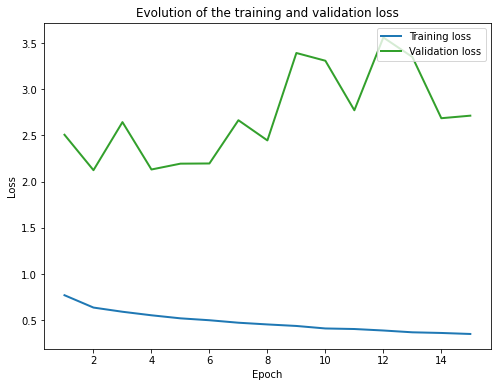

Computing accuracy...
Accuracy of the network on the 9914 train images: 80.84 %
Accuracy of the network on the 1000 validation images: 27.70 %
Accuracy of the network on the 2504 test images: 57.15 %
Class      Accuracy (%)
0            34.46   
1            74.02   
2            30.09   
******************************************************************
******************************************************************
******************************************************************
*****************       Signal: Throttle         *****************
******************************************************************
******************************************************************
******************************************************************
===== HYPERPARAMETERS =====
batch_size= 32
n_epochs= 15
learning_rate= 0.001
Epoch 1, 10% 	 train_loss: 0.93 took: 1.88s
Epoch 1, 20% 	 train_loss: 0.77 took: 1.74s
Epoch 1, 30% 	 train_loss: 0.69 took: 1.70s
Epoch 1, 40% 	 train_loss: 0.69 

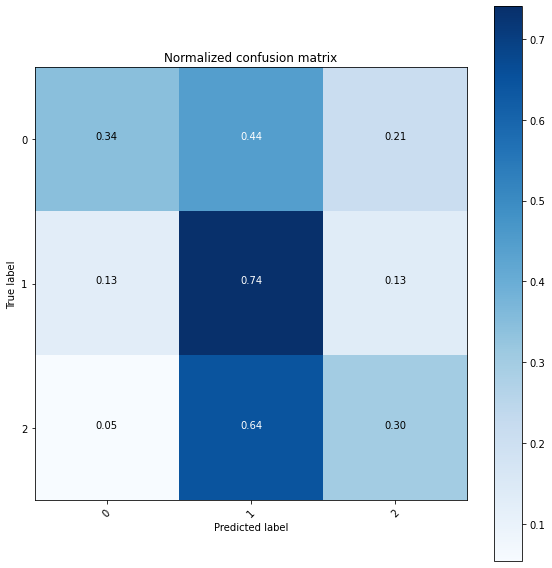

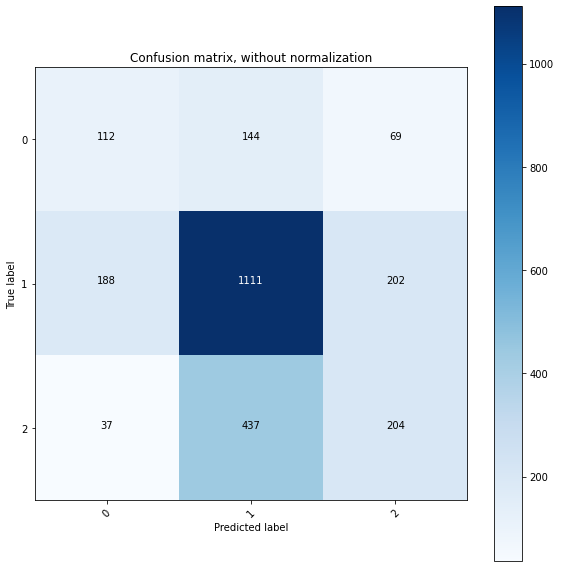

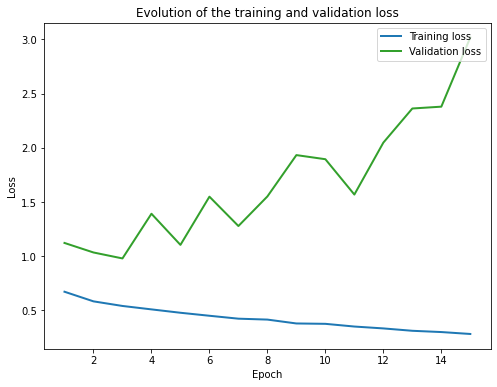

Computing accuracy...
Accuracy of the network on the 9914 train images: 81.93 %
Accuracy of the network on the 1000 validation images: 15.90 %
Accuracy of the network on the 2504 test images: 67.21 %
Class      Accuracy (%)
0            28.88   
1            85.03   
2            24.66   


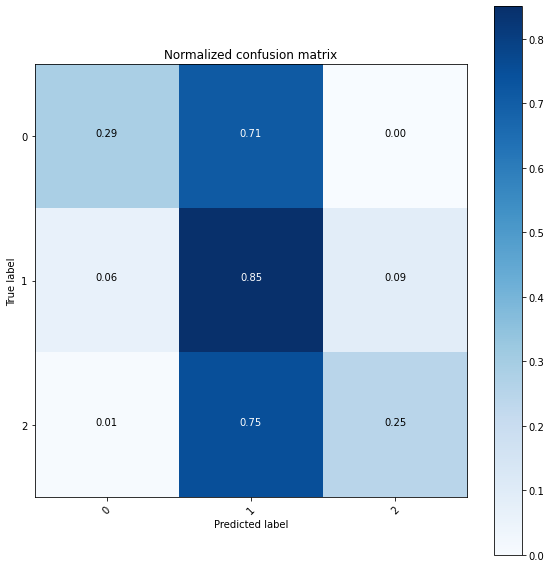

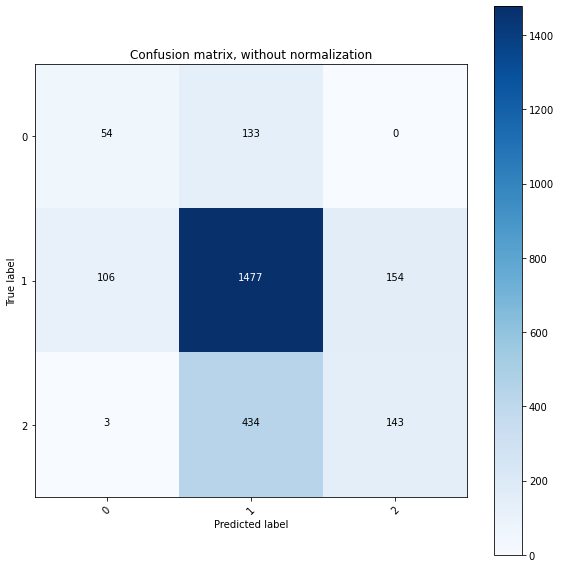

In [ ]:
num_workers = 2
test_batch_size = 64

# Transform the images to normalize them and downsample
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
     transforms.Resize((32,32))])

for signal in ['Steer', 'Throttle']:
  print(f'******************************************************************')
  print(f'******************************************************************')
  print(f'******************************************************************')
  print(f'*****************       Signal: {signal}         *****************')
  print(f'******************************************************************')
  print(f'******************************************************************')
  print(f'******************************************************************')

  train_set = torchvision.datasets.ImageFolder(root=os.path.join(root, 'Training', signal, 'Classified'), transform=transform)

  train_loader = torch.utils.data.DataLoader(train_set, batch_size=test_batch_size,
                                            num_workers=num_workers)

  test_set = torchvision.datasets.ImageFolder(root=os.path.join(root, 'Test', signal, 'Classified'), transform=transform)

  test_loader = torch.utils.data.DataLoader(test_set, batch_size=test_batch_size,
                                          num_workers=num_workers)

  from torch.utils.data.sampler import SubsetRandomSampler

  # Assume 1000 validation images
  n_training_samples = len(train_set) - 1000 
  n_val_samples = 1000

  train_sampler = SubsetRandomSampler(np.arange(n_training_samples, dtype=np.int64))
  val_sampler = SubsetRandomSampler(np.arange(n_training_samples, n_training_samples+ n_val_samples, dtype=np.int64))

  import torch.optim as optim

  def createLossAndOptimizer(net, learning_rate=0.0005):
      # it combines softmax with negative log likelihood loss
      criterion = nn.CrossEntropyLoss()  
      #optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
      optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=1e-4)
      return criterion, optimizer

  def get_train_loader(batch_size):
      return torch.utils.data.DataLoader(train_set, batch_size=batch_size, sampler=train_sampler,
                                                num_workers=num_workers)

  # # Use larger batch size for validation to speed up computation
  val_loader = torch.utils.data.DataLoader(train_set, batch_size=313, sampler=val_sampler,
                                            num_workers=num_workers)

  def train(net, batch_size, n_epochs, learning_rate):
      """
      Train a neural network and print statistics of the training
      
      :param net: (PyTorch Neural Network)
      :param batch_size: (int)
      :param n_epochs: (int)  Number of iterations on the training set
      :param learning_rate: (float) learning rate used by the optimizer
      """
      print("===== HYPERPARAMETERS =====")
      print("batch_size=", batch_size)
      print("n_epochs=", n_epochs)
      print("learning_rate=", learning_rate)
      print("=" * 30)
      
      train_loader = get_train_loader(batch_size)
      n_minibatches = len(train_loader)

      criterion, optimizer = createLossAndOptimizer(net, learning_rate)
      # Init variables used for plotting the loss
      train_history = []
      val_history = []

      training_start_time = time.time()
      best_error = np.inf
      best_model_path = "best_model.pth"
      
      device = 'cuda'

      # Move model to gpu if possible
      net = net.to(device)

      for epoch in range(n_epochs):  # loop over the dataset multiple times

          running_loss = 0.0
          print_every = n_minibatches // 10
          start_time = time.time()
          total_train_loss = 0
          
          opt_end = time.time()
          for i, (inputs, labels) in enumerate(train_loader):          
              # Move tensors to correct device
              inputs, labels = inputs.to(device), labels.to(device)

              # zero the parameter gradients
              optimizer.zero_grad()

              # forward + backward + optimize
              outputs = net(inputs)

              loss = criterion(outputs, labels)
              loss.backward()
              optimizer.step()
              
              # print statistics
              running_loss += loss.item()
              total_train_loss += loss.item()
              # print every 10th of epoch

              if (i + 1) % (print_every + 1) == 0:    
                  print("Epoch {}, {:d}% \t train_loss: {:.2f} took: {:.2f}s".format(
                        epoch + 1, int(100 * (i + 1) / n_minibatches), running_loss / print_every,
                        time.time() - start_time))
                  running_loss = 0.0
                  start_time = time.time()

              opt_end = time.time()

          train_history.append(total_train_loss / len(train_loader))

          total_val_loss = 0
          # Do a pass on the validation set
          # We don't need to compute gradient,
          # we save memory and computation using th.no_grad()
          
          with th.no_grad():
            for inputs, labels in val_loader:
                # Move tensors to correct device
                inputs, labels = inputs.to(device), labels.to(device)
                # Forward pass
                predictions = net(inputs)
                val_loss = criterion(predictions, labels)
                total_val_loss += val_loss.item()
              
          val_history.append(total_val_loss / len(val_loader))
          # Save model that performs best on validation set
          if total_val_loss < best_error:
              best_error = total_val_loss
              th.save(net.state_dict(), best_model_path)

          print("Validation loss = {:.2f}".format(total_val_loss / len(val_loader)))
          
      print("Training Finished, took {:.2f}s".format(time.time() - training_start_time))
      
      # Load best model
      # net.load_state_dict(th.load(best_model_path))

      return train_history, val_history

      device = th.device("cuda" if th.cuda.is_available() else "cpu")

  net = SimpleConvolutionalNetwork()

  train_history, val_history = train(net, batch_size=32, n_epochs=15, learning_rate=0.001)

  plot_losses(train_history, val_history)

  classes = ('0', '1', '2')

  def dataset_accuracy(net, data_loader, name=""):
      net = net.to(device)
      correct = 0
      total = 0
      for images, labels in data_loader:
          images, labels = images.to(device), labels.to(device)
          outputs = net(images)
          _, predicted = torch.max(outputs, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum()
      accuracy = 100 * float(correct) / total
      print('Accuracy of the network on the {} {} images: {:.2f} %'.format(total, name, accuracy))

  def train_set_accuracy(net):
      dataset_accuracy(net, train_loader, "train")

  def val_set_accuracy(net):
      dataset_accuracy(net, val_loader, "validation")  
      
  def test_set_accuracy(net):
      dataset_accuracy(net, test_loader, "test")

  def compute_accuracy(net):
      train_set_accuracy(net)
      val_set_accuracy(net)
      test_set_accuracy(net)
      
  print("Computing accuracy...")
  compute_accuracy(net)

  def accuracy_per_class(net):
      net = net.to(device)
      n_classes = 3
      # (real, predicted)
      confusion_matrix = np.zeros((n_classes, n_classes), dtype=np.int64)

      for images, labels in test_loader:
          images, labels = images, labels = images.to(device), labels.to(device)
          outputs = net(images)
          _, predicted = torch.max(outputs.data, 1)
          for i in range(predicted.size(0)):
              confusion_matrix[labels[i], predicted[i]] += 1
              label = labels[i]

      print("{:<10} {:^10}".format("Class", "Accuracy (%)"))
      for i in range(n_classes):
          class_total = confusion_matrix[i, :].sum()
          class_correct = confusion_matrix[i, i]
          percentage_correct = 100.0 * float(class_correct) / class_total
          
          print('{:<10} {:^10.2f}'.format(classes[i], percentage_correct))
      return confusion_matrix

  confusion_matrix = accuracy_per_class(net)

  # Plot normalized confusion matrix
  plot_confusion_matrix(confusion_matrix, classes, normalize=True,
                        title='Normalized confusion matrix')

  # Plot non-normalized confusion matrix
  plot_confusion_matrix(confusion_matrix, classes,
                        title='Confusion matrix, without normalization')